# PaySim NLP – Data Exploration Notebook
## Guardian Project – NLP Stream

This notebook performs **EDA for the PaySim dataset** to:
- Understand fraud distribution
- Identify usable text signals
- Validate mapping to NLPInput contract
- Establish baseline fraud metrics


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
print('Libraries loaded')

Libraries loaded


In [3]:
DATA_PATH = '../data/raw/paysim/paysim_data.csv'

df = pd.read_csv(DATA_PATH)

print('Dataset Shape:', df.shape)
df.head()

Dataset Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

## Fraud Distribution (CRITICAL)

This dataset is highly imbalanced. Accuracy is NOT a good metric.

**Key Metrics for Guardian Fraud Detection:**
- Recall (Most important)
- PR-AUC
- F1 Score
- ROC-AUC


In [6]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

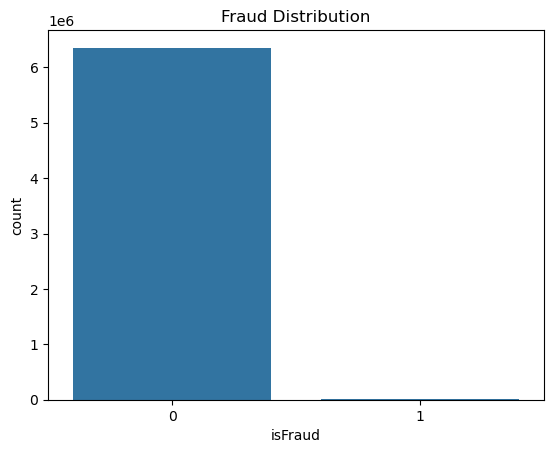

In [7]:
sns.countplot(x='isFraud', data=df)
plt.title('Fraud Distribution')
plt.show()

In [8]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [9]:
fraud_by_type = pd.crosstab(df['type'], df['isFraud'])
fraud_by_type

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


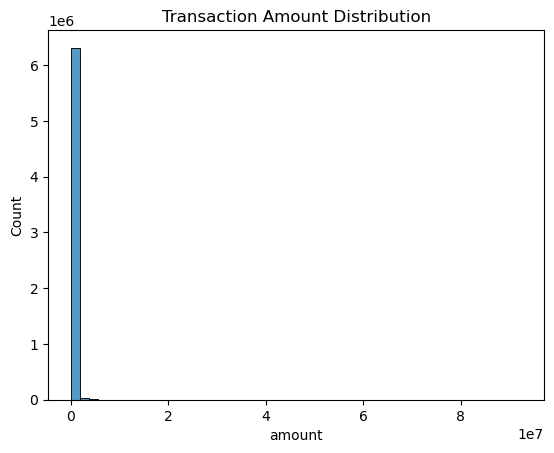

In [10]:
sns.histplot(df['amount'], bins=50)
plt.title('Transaction Amount Distribution')
plt.show()

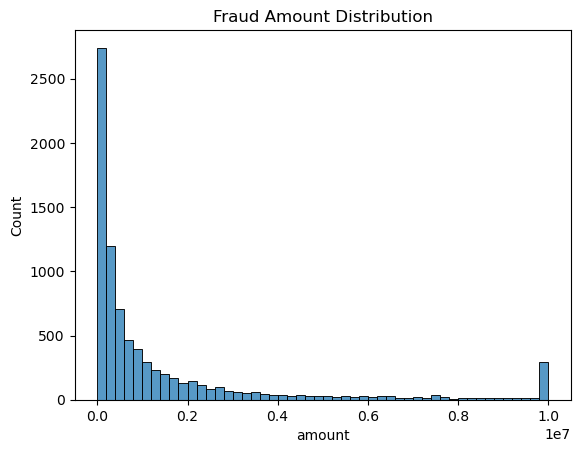

In [11]:
sns.histplot(df[df['isFraud']==1]['amount'], bins=50)
plt.title('Fraud Amount Distribution')
plt.show()

## Create Synthetic Transaction Text (NLP Signal Creation)

PaySim does not contain natural language text. We generate structured narrative text.


In [12]:
def create_transaction_text(row):
    return (
        f"Transaction type: {row['type']}. "
        f"Amount: {row['amount']}. "
        f"Origin balance before: {row['oldbalanceOrg']}. "
        f"Origin balance after: {row['newbalanceOrig']}. "
        f"Destination balance before: {row['oldbalanceDest']}. "
        f"Destination balance after: {row['newbalanceDest']}."
    )

df['transaction_text'] = df.apply(create_transaction_text, axis=1)

df['transaction_text'].iloc[0]

'Transaction type: PAYMENT. Amount: 9839.64. Origin balance before: 170136.0. Origin balance after: 160296.36. Destination balance before: 0.0. Destination balance after: 0.0.'

## Example Mapping → NLPInput Contract


In [13]:
sample = df.iloc[0]

nlp_input_example = {
    'transaction_id': str(sample.name),
    'text': sample['transaction_text'],
    'text_source': 'narrative',
    'language': 'en',
    'metadata': {
        'amount': float(sample['amount'])
    }
}

nlp_input_example

{'transaction_id': '0',
 'text': 'Transaction type: PAYMENT. Amount: 9839.64. Origin balance before: 170136.0. Origin balance after: 160296.36. Destination balance before: 0.0. Destination balance after: 0.0.',
 'text_source': 'narrative',
 'language': 'en',
 'metadata': {'amount': 9839.64}}

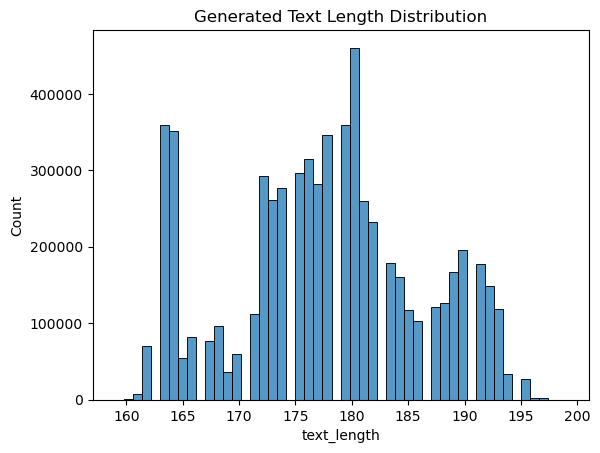

In [14]:
df['text_length'] = df['transaction_text'].apply(len)

sns.histplot(df['text_length'], bins=50)
plt.title('Generated Text Length Distribution')
plt.show()

In [15]:
from pathlib import Path
import json

df_nlp = pd.DataFrame({
    "transaction_id": df.index.astype(str),
    "text": df["transaction_text"],
    "label": df["isFraud"].astype("int8"),
    "amount": df["amount"].astype("float32"),
    "transaction_type": df["type"].astype(str)
})

out_dir = Path("../data/interim/paysim")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "paysim_nlp_interim.csv"
df_nlp.to_csv(csv_path, index=False)

print("Saved:", csv_path)

def to_nlp_input(row):
    return {
        "transaction_id": str(row.name),
        "text": row["transaction_text"],
        "text_source": "narrative",
        "language": "en",
        "metadata": {
            "amount": float(row["amount"]),
            "transaction_type": str(row["type"])
        }
    }

jsonl_path = out_dir / "paysim_nlpinput_sample.jsonl"

with open(jsonl_path, "w", encoding="utf-8") as f:
    for i in range(min(200, len(df))):
        f.write(json.dumps(to_nlp_input(df.iloc[i]), ensure_ascii=False) + "\n")

print("Saved:", jsonl_path)

Saved: ../data/interim/paysim/paysim_nlp_interim.csv
Saved: ../data/interim/paysim/paysim_nlpinput_sample.jsonl
